In [1]:
import pandas as pd

# Load datasets
news_data = pd.read_csv("../data/raw_analyst_ratings.csv", parse_dates=["date"])
import os

# Load stock datasets
stock_files = [file for file in os.listdir("../data/yfinance_data") if file.endswith('_historical_data.csv')]
stock_data = pd.concat([pd.read_csv(os.path.join("../data/yfinance_data", file), parse_dates=["Date"]) for file in stock_files])

# Preview datasets
print(news_data.head())
print(stock_data.head())


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [4]:
# Convert news dates to datetime format
news_data["date"] = pd.to_datetime(news_data["date"], format="%Y-%m-%d %H:%M:%S%z", errors='coerce')

# Normalize news dates (round down to the nearest day if time is included)
news_data["date"] = news_data["date"].dt.date

# Ensure stock dates only include trading days
stock_data["Date"] = stock_data["Date"].dt.date

# Merge datasets on dates
merged_data = pd.merge(news_data, stock_data, left_on="date", right_on="Date", how="inner")


Perform Sentiment Analysis

In [5]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download necessary resources
nltk.download("vader_lexicon")

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each headline
merged_data["sentiment_score"] = merged_data["headline"].apply(
    lambda text: sia.polarity_scores(text)["compound"]
)

# Preview results
print(merged_data[["date", "headline", "sentiment_score"]].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tesfa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


         date                                 headline  sentiment_score
0  2020-06-05  Stocks That Hit 52-Week Highs On Friday              0.0
1  2020-06-05  Stocks That Hit 52-Week Highs On Friday              0.0
2  2020-06-05  Stocks That Hit 52-Week Highs On Friday              0.0
3  2020-06-05  Stocks That Hit 52-Week Highs On Friday              0.0
4  2020-06-05  Stocks That Hit 52-Week Highs On Friday              0.0


Calculate Daily Stock Returns

In [6]:
merged_data["daily_return"] = merged_data["Close"].pct_change() * 100

# Preview data
print(merged_data[["Date", "Close", "daily_return"]].head())


         Date       Close  daily_return
0  2020-06-05   82.875000           NaN
1  2020-06-05  124.150002     49.803923
2  2020-06-05   71.919502    -42.070478
3  2020-06-05  230.770004    220.872638
4  2020-06-05  187.199997    -18.880273


Aggregate Sentiment Scores

In [7]:
daily_sentiment = merged_data.groupby("Date")["sentiment_score"].mean().reset_index()
daily_sentiment.columns = ["Date", "average_sentiment"]

# Merge back with stock returns
final_data = pd.merge(merged_data, daily_sentiment, on="Date", how="inner")


 Correlation Analysis

In [9]:
from scipy.stats import pearsonr
import numpy as np

# Drop rows with NaN or inf values
cleaned_data = final_data.replace([np.inf, -np.inf], np.nan).dropna(subset=["average_sentiment", "daily_return"])

# Calculate correlation
correlation, p_value = pearsonr(cleaned_data["average_sentiment"], cleaned_data["daily_return"])

print(f"Pearson Correlation: {correlation:.2f}")
print(f"P-value: {p_value:.4f}")


Pearson Correlation: 0.01
P-value: 0.0000


Visualize the Results

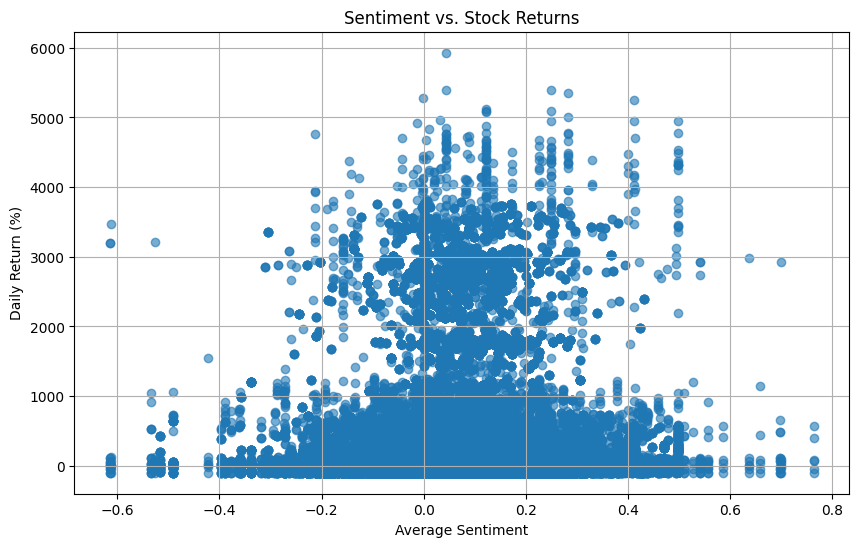

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(final_data["average_sentiment"], final_data["daily_return"], alpha=0.6)
plt.title("Sentiment vs. Stock Returns")
plt.xlabel("Average Sentiment")
plt.ylabel("Daily Return (%)")
plt.grid()
plt.show()


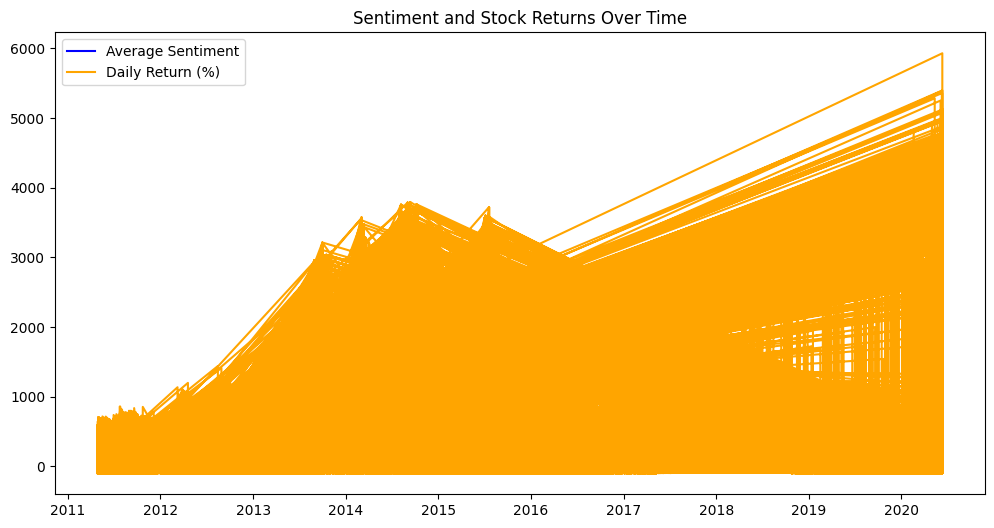

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(final_data["Date"], final_data["average_sentiment"], label="Average Sentiment", color="blue")
plt.plot(final_data["Date"], final_data["daily_return"], label="Daily Return (%)", color="orange")
plt.title("Sentiment and Stock Returns Over Time")
plt.legend()
plt.show()
